In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)

Using TensorFlow backend.


## Loading Images from Directory as Training and Validation Set

We use Keras flow_from_directory API to not overload the computer memory. ImageDataGenerator class has been used to create train and validation set. However, since we are creating a mixed input deep network, we have to design a custom data generator to genearte mixed data (Image and Numeric features) on the fly. 

### Define image height, width, training batch size, number of classes, and class names here
We want to identify cull vs good sweetpotato

In [2]:

py = 128*2  # height
px = 96*2  # widht
batch_size=32


class_names=['Cull','Good']
class_num=len(class_names)

We use a 80% : 20% training and validation split resulting in 

### 1080 Training images
### 269 Validation images

In [3]:
train_datagen = ImageDataGenerator(
        rescale=1. / 255, dtype=np.float32, horizontal_flip=True, vertical_flip=True, validation_split=0.2,
        rotation_range=15)

test_datagen = ImageDataGenerator(rescale=1. / 255, dtype=np.float32)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'L:/Sweetpotato Classification/Data/Training_Binary_Kenn',  # this is the target directory
        target_size=(py, px,3),  # all images will be resized to height*width
        batch_size=batch_size,
        class_mode='categorical', subset='training',
        classes=class_names)  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = train_datagen.flow_from_directory(
        'L:/Sweetpotato Classification/Data/Training_Binary_Kenn',
        target_size=(py, px,3),
        batch_size=batch_size,        
        class_mode='categorical', subset='validation', classes=class_names)

Found 1080 images belonging to 2 classes.
Found 269 images belonging to 2 classes.


## Pretrained VGG 16 Model

We load the VGG16 model with pretrained weight, excluding the top layer and freez the Convolutional layers during training

In [4]:
from keras.applications.vgg16 import VGG16
model_vgg16_conv = VGG16(weights='imagenet', include_top=False,input_shape=(py,px,3))
#model_vgg16_conv.summary()

#keras_input = Input(shape=(py,px,3,), name = 'image_input')
    
#Use the generated model 
#output_vgg16_conv = model_vgg16_conv(keras_input)
for layer in model_vgg16_conv.layers[:-4]:
    layer.trainable = False 

Instructions for updating:
Colocations handled automatically by placer.


## Neural Network Model

We define our nerual network model that will use the engineered features for classification

In [5]:

modelNN=Sequential()
modelNN.add(Dense(32,input_dim=11))
modelNN.add(Dense(8, activation="relu"))
modelNN.add(Dense(8, activation="relu"))


## Merging two branches 

We flatten the outputs from VGG16 and merge it with final dense layer of the Neural Network, add final layers and complete the model

In [6]:
from keras.layers import concatenate
flattenvgg16=Flatten()(model_vgg16_conv.output)
combinedInput = concatenate([flattenvgg16, modelNN.output])

x = Dense(64, activation="relu")(combinedInput)
x = Dense(2, activation="relu")(x)
x =Dense(2, activation="softmax")(x)

model = Model(inputs=[model_vgg16_conv.input, modelNN.input], outputs=x)

### Define optimizer and compile the model

In [7]:
from keras.optimizers import Adam
opt = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=["accuracy"])

## Visualize the network structure

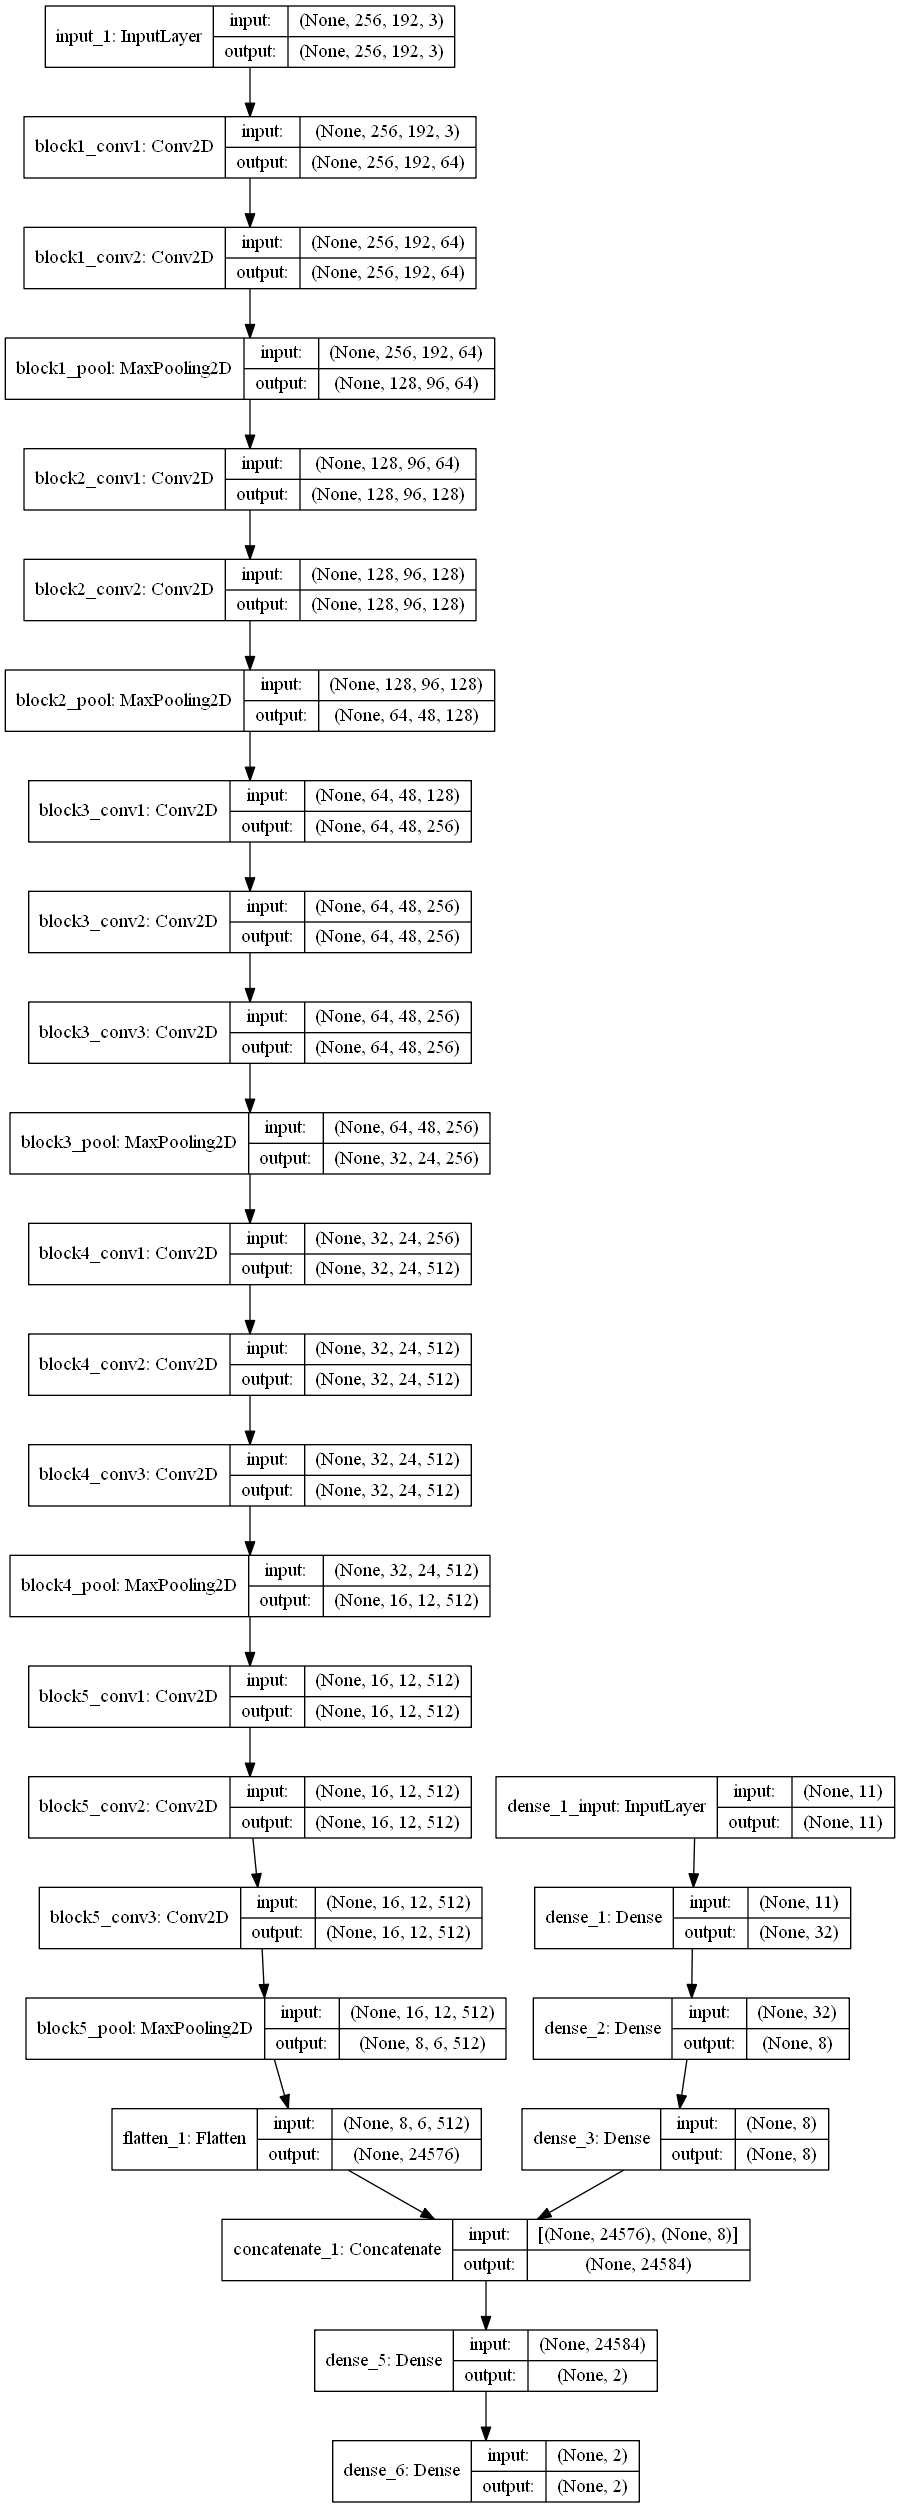

In [8]:
%matplotlib inline
from keras.utils.vis_utils import plot_model
plot_model(model,  to_file='model_plot.png',show_shapes=True, show_layer_names=True);
from IPython.display import Image 
Image('model_plot.png') #export as png image

## Custom generator from mixed input


We have image data and numeric features in csv (dataframe) format. A custom generator will generate mixed inputs with labels on the fly. This generator allow us to use the fit_predictor api for model training. 

In [9]:
# cocept adapted from https://stackoverflow.com/questions/55266249/create-a-mixed-data-generator-images-csv-in-keras/55267337
from keras.preprocessing import image as krs_image
import random
import threading


def custom_generator(batch_size,images_list,feature_dataframe,validation=False):
    idx=0
    #images_list=train_generator.filepaths
    # dataframe=feature_df=pd.read_csv('df_csv.csv',index_col='Title')
  
    data_gen_args = dict(
    horizontal_flip=True,
    shear_range=10,
    channel_shift_range=50,
    rescale=1. / 255)
    num_classes=2
    i = 0
    datagen = ImageDataGenerator()
    random.shuffle(images_list)
    while True:
        batch = {'images': [], 'csv': [], 'labels': []}
        for b in range(batch_size):
            if i == len(images_list):
                i = 0
                random.shuffle(images_list)
            # Read image from list and convert to array
            image_path = images_list[i]
            image_name = os.path.basename(image_path)
            image = krs_image.load_img(image_path, target_size=(py, px))
            if validation==False:
                image = datagen.apply_transform(image, data_gen_args)
            
            image = krs_image.img_to_array(image)
            
            # Read data from csv using the name of current image

            try:
                csv_row = feature_dataframe.loc[image_name, :]
            except KeyError:
                i += 1
                continue
            label = csv_row['Shape']
            
            csv_features = csv_row.drop(labels='Shape')

            batch['images'].append(image)
            batch['csv'].append(csv_features)
            batch['labels'].append(label)
           
            i += 1

        batch['images'] = np.array(batch['images'])
        batch['csv'] = np.array(batch['csv'])
       
        # Convert labels to categorical values
       
        one_hot = [0 if x=='Cull' else 1 for x in batch['labels']]        
        batch['labels'] = np.eye(num_classes)[one_hot]
        #print('generator yielded a batch %d' % idx)
        idx+=1
        yield [batch['images'], batch['csv']], batch['labels']


## Read features from csv 

In [11]:
feature_df=pd.read_csv('df_csv.csv',index_col='Title')


## Create training and validation image path list

In [12]:
tr_im_list=train_generator.filepaths
val_im_list=validation_generator.filepaths

## Custom data  generator for training and validation

In [13]:

custom_train_gen=custom_generator(batch_size=batch_size,images_list=tr_im_list,feature_dataframe=feature_df)

custom_validation_gen=custom_generator(batch_size=batch_size,images_list=val_im_list,
                                       feature_dataframe=feature_df,validation=True)

## Train the model

In [16]:
H=model.fit_generator(custom_train_gen,steps_per_epoch=np.ceil(train_generator.samples/batch_size),
        epochs=200,validation_data=custom_validation_gen,validation_steps=np.ceil(validation_generator.samples/batch_size));


Epoch 1/200
 1/34 [..............................] - ETA: 1:54 - loss: 0.6688 - accuracy: 0.6875

KeyboardInterrupt: 